In [1]:
import os
import sys
import copy
import numpy as np
import pickle
import torch
import torchvision.models as models

from PIL import Image

from torch.autograd import Variable
from torch.nn import functional as F

In [2]:
with open("imagenet_labels.pkl", "rb") as f:
    class_name = pickle.load(f)

In [3]:
model = models.resnet18(pretrained=True)

In [4]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [5]:
import requests
# IMAGENET
img_url = "http://farm2.static.flickr.com/1131/681589138_e4b702f863.jpg"
get_img = requests.get(img_url)

open('test.png', 'wb').write(get_img.content)

79701

Target Class Number : 537 
Target Class Name : dogsled, dog sled, dog sleigh


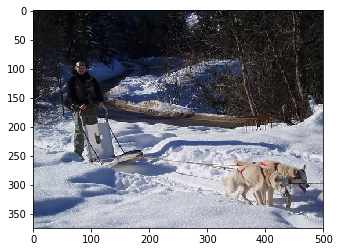

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

img_path = 'test.png'
target = 537

img = Image.open(img_path)

plt.imshow(img)

print("Target Class Number : %d \nTarget Class Name : %s" % (target, class_name[target]))

In [7]:
grads = None

def hook_function(module, grad_input, grad_output):
    global grads
    
    grads = grad_input[0]
    
first_layer = list(model._modules.items())[0][1]
first_layer.register_backward_hook(hook_function)

In [8]:
import torchvision.transforms as transforms
from torch.autograd import Variable

cvt_tensor = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

tensor_img = cvt_tensor(img).view(1, 3, 224, 224)
tensor_img = Variable(tensor_img, requires_grad=True)

In [9]:
model.zero_grad()

output = model(tensor_img)

one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
one_hot_output[0][target] = 1

output.backward(gradient=one_hot_output)

In [10]:
grad_img = grads.cpu().data.numpy()[0]

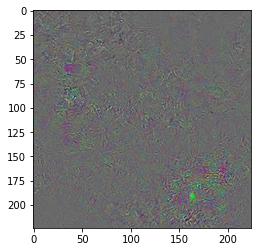

In [11]:
def scaling(img):
    img = img - np.min(img)
    img = img / np.max(img)
    
    return img

scaled_grad_img = scaling(grad_img)

scaled_grad_img = scaled_grad_img.transpose(1,2,0)

if np.max(scaled_grad_img) <= 1:
    scaled_grad_img = (scaled_grad_img*255).astype(np.uint8)
    
plt.imshow(scaled_grad_img)

In [12]:
def convert_to_grayscale(im_as_arr):
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im

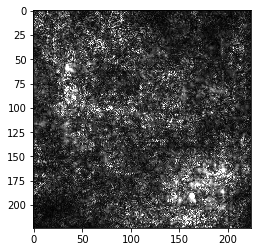

In [13]:
grad_times_img = convert_to_grayscale(grad_img)

grad_times_img = grad_times_img - grad_times_img.min()
grad_times_img /= grad_times_img.max()

grad_times_img = np.repeat(grad_times_img, 3, axis=0)
grad_times_img = grad_times_img.transpose(1,2,0)

plt.imshow(grad_times_img)